In [55]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [56]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    glucose_levels = []
    basal_insulin = []
    bolus_insulin = []
    carbs = []
    timestamps = []

    # Extract glucose levels
    for glucose_event in root.findall(".//glucose_level/event"):
        ts = glucose_event.get('ts')
        value = float(glucose_event.get('value'))
        glucose_levels.append((ts, value))

    # Extract basal insulin
    for basal_event in root.findall(".//basal/event"):
        ts = basal_event.get('ts')
        value = float(basal_event.get('value'))
        basal_insulin.append((ts, value))

    # Extract bolus insulin
    for bolus_event in root.findall(".//bolus/event"):
        ts = bolus_event.get('ts_begin')
        dose = float(bolus_event.get('dose'))
        bolus_insulin.append((ts, dose))

    # Extract meal data
    for meal_event in root.findall(".//meal/event"):
        ts = meal_event.get('ts')
        carbs_value = float(meal_event.get('carbs'))
        carbs.append((ts, carbs_value))

    # Combine all data into a DataFrame
    data = []
    for ts, glucose in glucose_levels:
        basal = next((value for t, value in basal_insulin if t == ts), 0)
        bolus = next((dose for t, dose in bolus_insulin if t == ts), 0)
        meal = next((carbs_value for t, carbs_value in carbs if t == ts), 0)
        data.append((ts, glucose, basal, bolus, meal))

    df = pd.DataFrame(data, columns=['timestamp', 'glucose', 'basal_insulin', 'bolus_insulin', 'carbs'])
    
    # Specify the correct format for parsing the timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M:%S')
    
    return df


In [57]:
training_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/540-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/544-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/552-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/567-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/584-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/596-ws-training.xml'
]

# Paths to testing XML files
testing_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/540-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/544-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/552-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/567-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/584-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/596-ws-testing.xml'
]

# Load and preprocess training data
training_data = [parse_xml(file) for file in training_files]
training_df = pd.concat([data for data in training_data])

# Load and preprocess testing data
testing_data = [parse_xml(file) for file in testing_files]
testing_df = pd.concat([data for data in testing_data])
print(training_df,testing_df)



                timestamp  glucose  basal_insulin  bolus_insulin  carbs
0     2027-05-19 11:36:29     76.0            0.0            0.0    0.0
1     2027-05-19 11:41:29     72.0            0.0            0.0    0.0
2     2027-05-19 11:46:29     68.0            0.0            0.0    0.0
3     2027-05-19 11:51:29     65.0            0.0            0.0    0.0
4     2027-05-19 11:56:29     63.0            0.0            0.0    0.0
...                   ...      ...            ...            ...    ...
10872 2027-05-26 23:39:00    170.0            0.0            0.0    0.0
10873 2027-05-26 23:44:00    172.0            0.0            0.0    0.0
10874 2027-05-26 23:49:00    173.0            0.0            0.0    0.0
10875 2027-05-26 23:54:00    174.0            0.0            0.0    0.0
10876 2027-05-26 23:59:00    174.0            0.0            0.0    0.0

[65535 rows x 5 columns]                timestamp  glucose  basal_insulin  bolus_insulin  carbs
0    2027-07-04 00:01:44    254.0      

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features: glucose, basal insulin, bolus insulin, carbs
training_features = training_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values
testing_features = testing_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values

training_scaled = scaler.fit_transform(training_features)
testing_scaled = scaler.transform(testing_features)


In [59]:
def create_sequences(data, time_steps=10, horizon=30):
    X, y = [], []
    for i in range(len(data) - time_steps - horizon):
        X.append(data[i:i+time_steps, :-1])  # All features except glucose
        y.append(data[i+time_steps+horizon-1, 0])  # Glucose value at the horizon as target
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_scaled, time_steps=3)
X_test, y_test = create_sequences(testing_scaled, time_steps=3)


In [ ]:

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
predictions = model.predict(X_test)


# Rescale predictions and actual values back to original scale
# Rescale predictions and actual values back to original scale
predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros_like(predictions), np.zeros_like(predictions), np.zeros_like(predictions)], axis=-1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1))], axis=-1))[:, 0]


Epoch 1/200


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
from sklearn.metrics import mean_squared_error


def evaluate_model(model, X_test, y_test, time_steps):
    # Ensure the test data is properly shaped for LSTM
    X_test_lstm = []
    for i in range(time_steps, len(X_test)):
        X_test_lstm.append(X_test[i-time_steps:i, :])
    X_test_lstm = np.array(X_test_lstm)
    print(X_test_lstm)
    predictions = model.predict(X_test_lstm)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test[time_steps:], predictions))
    print(f'RMSE: {rmse}')
    
    return predictions

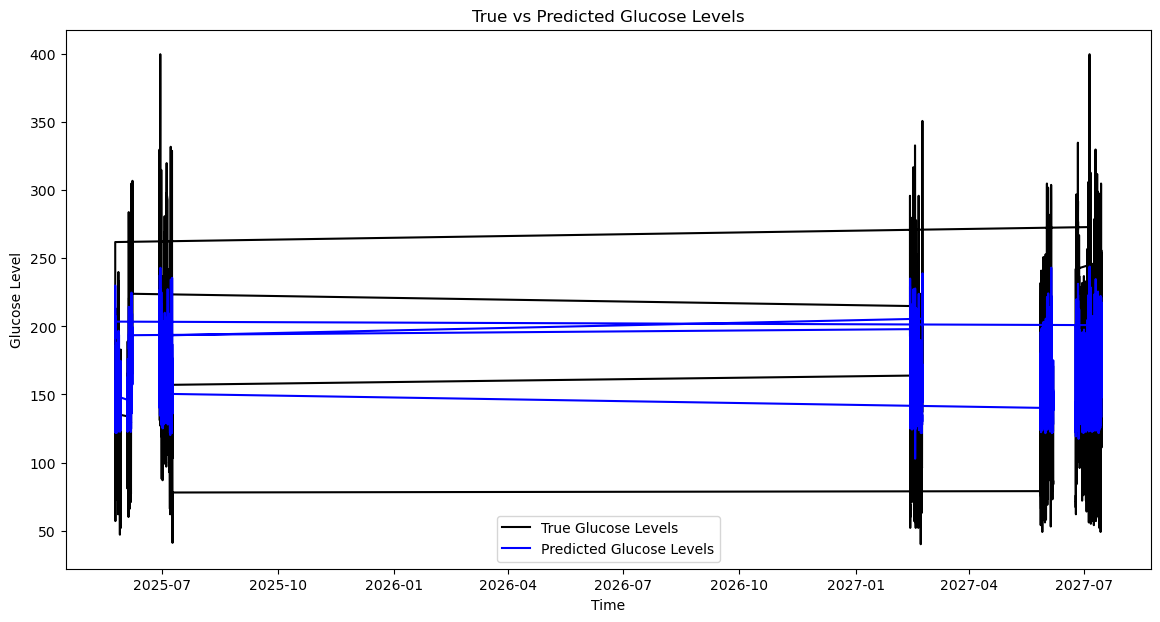

In [62]:
plt.figure(figsize=(14, 7))
plt.plot(testing_df['timestamp'][len(testing_df) - len(y_test_rescaled):], y_test_rescaled, label='True Glucose Levels', color='black')
plt.plot(testing_df['timestamp'][len(testing_df) - len(predictions_rescaled):], predictions_rescaled, label='Predicted Glucose Levels', color='blue')
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.title('True vs Predicted Glucose Levels')
plt.legend()
plt.show()


In [63]:
from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 53.74182903495043


In [64]:
from sklearn.metrics import mean_absolute_error


mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 42.7984887347288


In [42]:
def compute_time_gain(Ts, PH, y_true, y_pred):
    """
    Compute the Time Gain (TG) for glucose level prediction in T1DM.

    Parameters:
    Ts (float): Sampling time
    PH (int): Prediction horizon
    y_true (numpy array): True glucose levels
    y_pred (numpy array): Predicted glucose levels

    Returns:
    TG (numpy array): Time Gain values
    """
    TG = np.zeros(PH)
    for i in range(PH):
        delay = np.abs(y_true[i] - y_pred[i])
        TG[i] = (i + 1) * Ts - delay
    return TG